In [ ]:
!pip install pandas
!pip install numpy
!pip install scipy
!pip install matplotlib
!pip install seaborn
!pip install statsmodels
#!pip install prophet
!pip install scikit-learn
!pip install plotly
!pip install neuralprophet[live]

In [186]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

import pandas as pd
import numpy as np
from itertools import product
import datetime
from scipy import interpolate
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
from pylab import rcParams
import seaborn as sns
import statsmodels.api as sm
import math
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from neuralprophet import NeuralProphet
from neuralprophet import set_random_seed
from neuralprophet import save
from neuralprophet import load

plt.rc("font", family="Malgun Gothic")
plt.rcParams['axes.unicode_minus'] = False

### 데이터 불러오기

In [2]:
# 학습 데이터
data_tr = pd.read_csv('./t1_data_city/data_tr_city.csv')
data_tr

,datetime,구미 혁신도시배수지 유출유량 적산차
0,2017-01-01 01:00:00,138.0
1,2017-01-01 02:00:00,237.0
2,2017-01-01 03:00:00,128.0
3,2017-01-01 04:00:00,14.0
4,2017-01-01 05:00:00,11.0
...,...,...
35058,2020-12-31 19:00:00,328.0
35059,2020-12-31 20:00:00,347.0
35060,2020-12-31 21:00:00,335.0
35061,2020-12-31 22:00:00,141.0


In [3]:
# 평가 데이터
data_ts = pd.read_csv('./t1_data_city/data_ts_city.csv')
data_ts

,datetime,구미 혁신도시배수지 유출유량 적산차
0,2021-01-01 00:00:00,106.0
1,2021-01-01 01:00:00,184.0
2,2021-01-01 02:00:00,277.0
3,2021-01-01 03:00:00,197.0
4,2021-01-01 04:00:00,72.0
...,...,...
8419,2021-12-17 19:00:00,327.0
8420,2021-12-17 20:00:00,513.0
8421,2021-12-17 21:00:00,396.0
8422,2021-12-17 22:00:00,350.0


In [4]:
# 제출 양식
data_sample = pd.read_csv('./t1_data_city/sample_city.csv')
data_sample

,datetime,h0,h1,h2,h3,h4,h5,h6,h7,h8,...,h326,h327,h328,h329,h330,h331,h332,h333,h334,h335
0,2021-01-01 00:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2021-01-01 01:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2021-01-01 02:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2021-01-01 03:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2021-01-01 04:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8420,2021-12-17 20:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8421,2021-12-17 21:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8422,2021-12-17 22:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8423,2021-12-17 23:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 복잡한 컬럼명 변경

In [5]:
data_tr.rename(columns= {'구미 혁신도시배수지 유출유량 적산차':'적산차'}, inplace=True)
data_ts.rename(columns= {'구미 혁신도시배수지 유출유량 적산차':'적산차'}, inplace=True)
data_tr.head()

,datetime,적산차
0,2017-01-01 01:00:00,138.0
1,2017-01-01 02:00:00,237.0
2,2017-01-01 03:00:00,128.0
3,2017-01-01 04:00:00,14.0
4,2017-01-01 05:00:00,11.0


### 결측치 확인

In [6]:
data_tr[data_tr.적산차.isnull()]

,datetime,적산차
1748,2017-03-14 21:00:00,NaN
1982,2017-03-24 15:00:00,NaN
12716,2018-06-14 21:00:00,NaN
12717,2018-06-14 22:00:00,NaN
13187,2018-07-04 12:00:00,NaN
13234,2018-07-06 11:00:00,NaN
27253,2020-02-10 14:00:00,NaN
27254,2020-02-10 15:00:00,NaN


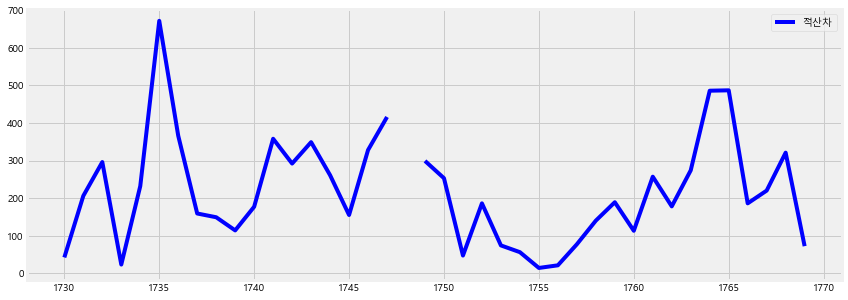

In [7]:
# 결측치 중 한 곳을 시각화
rcParams['figure.figsize'] = 13, 5
data_tr[1730:1770].plot(c='blue')
plt.show()

In [8]:
# linear 보간을 통해 결측치 처리
data_tr_interpolate = data_tr.interpolate(method = 'linear')

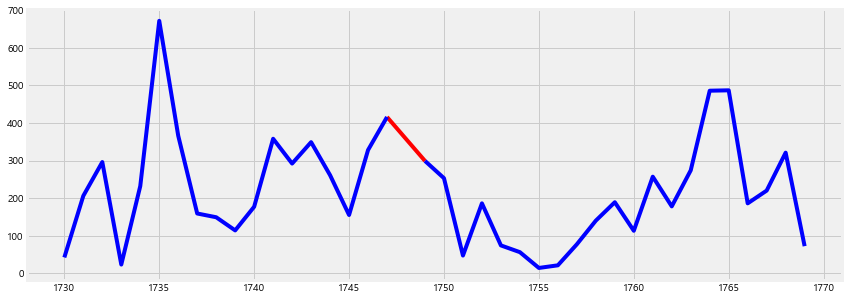

In [9]:
# 보간 후 데이터 시각화
data_tr_interpolate[1747:1750].적산차.plot(c='red')
data_tr[1730:1770].적산차.plot(c='blue')
plt.show()

data_tr = data_tr_interpolate

### 이상치 변환

#### 이상치 제거

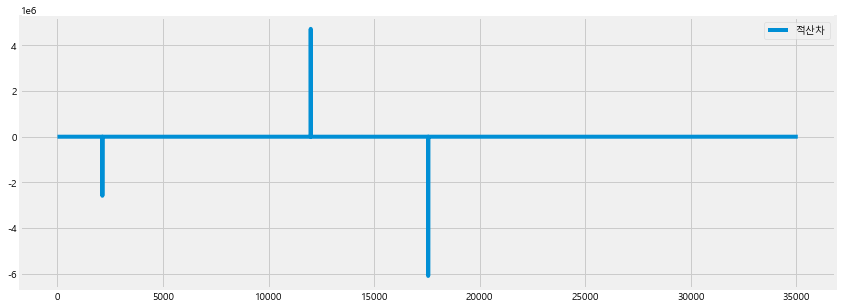

In [10]:
rcParams['figure.figsize'] = 13, 5
data_tr.plot()
plt.show()

In [11]:
index = data_tr[data_tr.적산차 == max(data_tr.적산차)].index
print(index)
data_tr.적산차[index] = np.NaN

Int64Index([11995], dtype='int64')


In [12]:
index = data_tr[data_tr.적산차 == min(data_tr.적산차)].index
print(index)
data_tr.적산차[index] = np.NaN

Int64Index([17558], dtype='int64')


In [13]:
index = data_tr[data_tr.적산차 == min(data_tr.적산차)].index
print(index)
data_tr.적산차[index] = np.NaN

Int64Index([2127], dtype='int64')


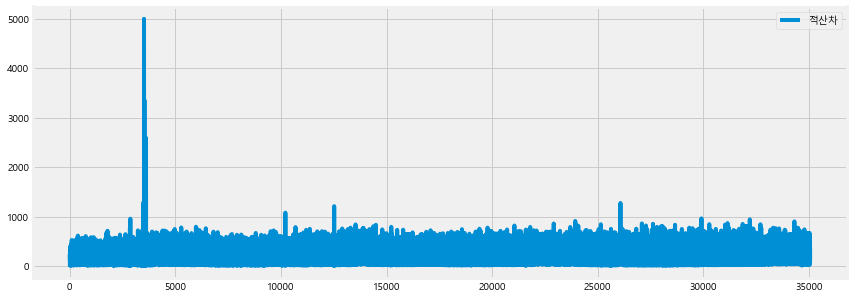

In [14]:
data_tr.plot()
plt.show()

In [15]:
# linear 보간을 통해 결측치 처리
data_tr_interpolate = data_tr.interpolate(method = 'linear')
data_tr = data_tr_interpolate

In [16]:
data_tr.reset_index(drop=True, inplace=True)

In [17]:
data_tr['datetime'] = pd.to_datetime(data_tr['datetime'])
data_tr.set_index('datetime', inplace=True)

data_ts['datetime'] = pd.to_datetime(data_ts['datetime'])
data_ts.set_index('datetime', inplace=True)

data_tr

,적산차
datetime,
2017-01-01 01:00:00,138.0
2017-01-01 02:00:00,237.0
2017-01-01 03:00:00,128.0
2017-01-01 04:00:00,14.0
2017-01-01 05:00:00,11.0
...,...
2020-12-31 19:00:00,328.0
2020-12-31 20:00:00,347.0
2020-12-31 21:00:00,335.0


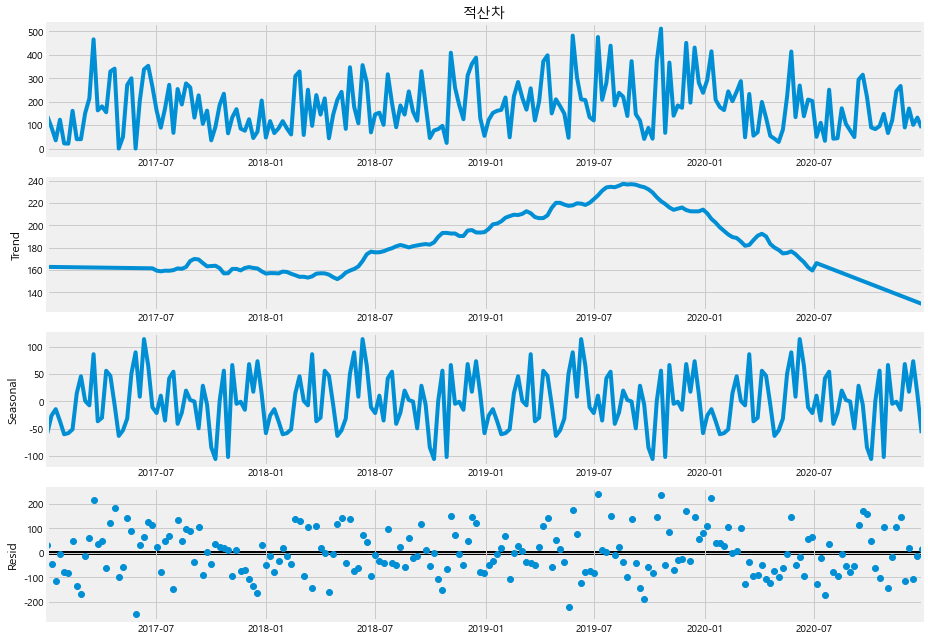

In [18]:
rcParams['figure.figsize'] = 13, 9
decomposed_df_volume = sm.tsa.seasonal_decompose(data_tr['적산차'].asfreq('W'), extrapolate_trend='freq', period=52) # py3.6 이하는 freq=52 가능
figure = decomposed_df_volume.plot()
plt.show()

* 1년의 계절성을 지녔음

In [19]:
meanperhour = []

for i in tqdm(range(24)):
    ytemp = []
    for j in range(len(data_tr)):
        hour = int(str(data_tr.index[j]).split()[1][:2])
        if i == j:
            ytemp.append(data_tr.적산차[i])
    meanperhour.append(np.mean(ytemp))
print(meanperhour)

100%|██████████| 24/24 [00:06<00:00,  3.81it/s]

[138.0, 237.0, 128.0, 14.0, 11.0, 10.0, 11.0, 187.0, 392.0, 114.0, 243.0, 203.0, 250.0, 181.0, 141.0, 148.0, 132.0, 199.0, 202.0, 245.0, 308.0, 152.0, 197.0, 175.0]


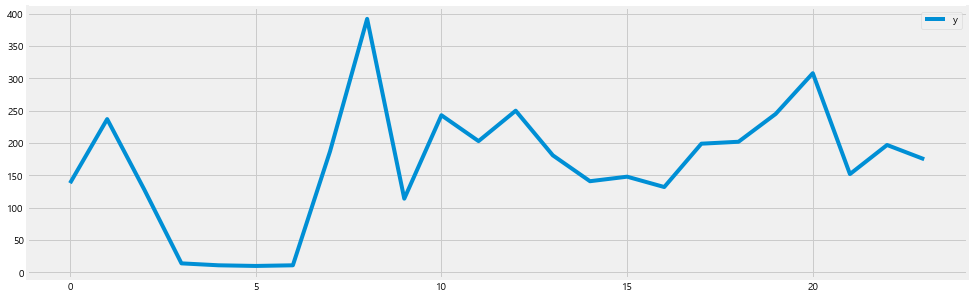

In [20]:
rcParams['figure.figsize'] = 15, 5
pd.DataFrame({'y':meanperhour}).plot()
plt.show()

## Neural Prophet

* 스탠포드 대학교와 메타가 PyTorch를 활용하여 개발하여 기존 prophet 모델에서 개선된 딥러닝 모델

In [187]:
data_tr_prophet = data_tr.copy()
data_tr_prophet.rename(columns= {'적산차':'y'}, inplace=True)
data_tr_prophet['ds'] = data_tr_prophet.index
data_tr_prophet.reset_index(drop=True, inplace=True)

data_ts_prophet = data_ts.copy()
data_ts_prophet.rename(columns= {'적산차':'y'}, inplace=True)
data_ts_prophet['ds'] = data_ts_prophet.index
data_ts_prophet.reset_index(drop=True, inplace=True)

In [ ]:
'''
yearly_seasonality = [5, 10, 20]
weekly_seasonality = [5, 10, 20]
daily_seasonality = [5, 10, 20]
num_hidden_layers = [2, 4, 8]
d_hidden = [48, 128, 256, 512]

nprophet_params = [(x[0], x[1], x[2], x[3], x[4]) 
                   for x in list(product(yearly_seasonality,
                                weekly_seasonality,
                                daily_seasonality,
                                num_hidden_layers,
                                d_hidden
                                ))]

best_mae, cnt = '', 0

for ys, ws, ds, nhl, dh in tqdm(nprophet_params):
    m = NeuralProphet(
        seasonality_mode='multiplicative',
        changepoints_range=0.95,
        #growth='decontinuous', #off, leaner, decontinuous
        yearly_seasonality=ys,
        weekly_seasonality=ws,
        daily_seasonality=ds,
        #n_changepoints=nc,
        #seasonality_reg=sr,
        #ar_reg=ar,
        #trend_reg=tr,
        num_hidden_layers=nhl, # 은닉층 수
        d_hidden=dh, # 은닉층 차원 수
        learning_rate=0.1,
        epoch=100
    )    
    
    metrics = m.fit(data_tr_prophet, freq='H')

    forecast = m.predict(data_ts_prophet)
    mae = mean_absolute_error(forecast['y'], forecast['yhat1'])
    
    if cnt == 0:
        cnt += 1
        best_mae = mae
        
    if best_mae > mae:
        best_mae = mae
        best_param = [ys, ws, ds, nhl, dh]
    
    clear_output()
    
    print(f'ys={ys}, ws={ws}, ds={ds}, nc={nc}, nhl={nhl}, dh={dh}, mae={mae}, best mae={best_mae}')
'''

* 하이퍼 파라미터 튜닝 드가자~

In [ ]:
'''
m = NeuralProphet(
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=True,
    trend_reg=100,
)
'''

In [232]:
set_random_seed(42)

m = NeuralProphet(
    n_lags=24*14, # 2주 분량의 데이터 트랜드를 강조
    n_forecasts=24*14, # 수치만큼 yhat을 생성. yhat_n은 이전 행의 yhat_n-1 까지의 값으로 예측됨. 예측값들로 예측(초반엔 예측된 데이터가 부족하므로 실제 데이터도 활용)
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=True,
    #num_hidden_layers=8, # 은닉층 수 # 레이어가 많으면 고차원에 유리, 적으면 집중
    #d_hidden=256, # 은닉층 차원 수 # 레이어와 음의 상관관계를 유지하는게 좋음. 레이어 많으면 줄이는 방향으로
    learning_rate=0.1,
    epochs=175, # epcch가 많으면 과적합될 수 있음
    batch_size=64, # 2021 페이스북 논문서 32~128이 좋다고 함. 같은 시간동안 학습 시, 배치사이즈와 학습률이 높은 경우가 좋았다고 함. -> 128
)    

#m.utils.set_random_seed(seed=0)
metrics = m.fit(data_tr_prophet, freq='H')

forecast = m.predict(pd.concat([data_tr_prophet[len(data_tr_prophet)-24*14:], data_ts_prophet], ignore_index=True))
mae = mean_absolute_error(forecast['y'][24*14:], forecast['yhat1'][24*14:])

print(mae)


INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.997% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
Epoch[150/150]: 100%|██████████| 150/150 [02:19<00:00,  1.07it/s, SmoothL1Loss=0.0222, MAE=84.4, RMSE=112, Loss=0.0165, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


84.77437452304355


In [233]:
save(m, "neuralprophet.np")

#m = load("neuralprophet.np")

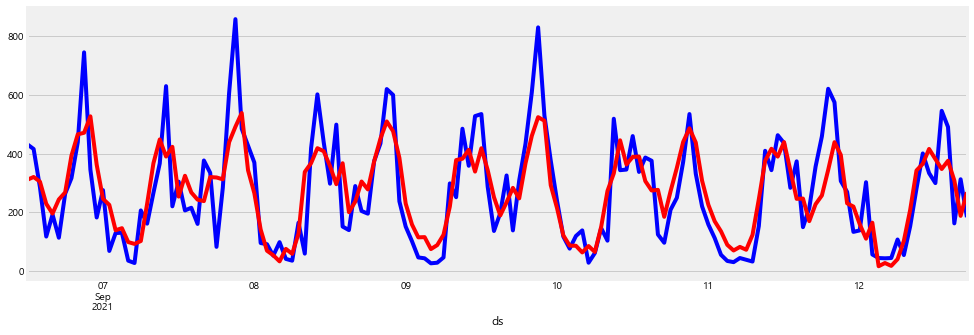

In [234]:
rcParams['figure.figsize'] = 15, 5
forecast.set_index('ds')[6300:6450].y.plot(c='blue')
forecast.set_index('ds')[6300:6450].yhat1.plot(c='red')
plt.show()

In [205]:
df_test_lags = pd.concat([data_tr_prophet[len(data_tr_prophet)-(24*14):], data_ts_prophet], ignore_index=True)

for i, start in enumerate(tqdm(data_sample.datetime)):
    #start = pd.to_datetime(start)
    ds = pd.date_range(start ,start + datetime.timedelta(hours=335), freq='H')
    df_test = pd.concat([df_test_lags[i:i+(24*14)], pd.DataFrame({'ds':ds, 'y':[0]*len(ds)})], ignore_index=True)
    
    forecast = m.predict(df_test)
    
    result = []
    for j in range(336):
        result.append(forecast['yhat'+str(j+1)][j+24*14])

    data_sample.loc[i] = [start] + result
    clear_output()

data_sample

  2%|▏         | 164/8425 [01:33<1:14:49,  1.84it/s]INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.851% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.901% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
  2%|▏         | 164/8425 [01:33<1:18:36,  1.75it/s]


KeyboardInterrupt: 

In [139]:
'''
df_test_lags = pd.concat([data_tr_prophet[len(data_tr_prophet)-(24*14):], data_ts_prophet], ignore_index=True)

for i, start in enumerate(tqdm(data_sample.datetime)):
    #start = pd.to_datetime(start)
    ds = pd.date_range(start ,start + datetime.timedelta(hours=335), freq='H')
    df_test = pd.concat([df_test_lags[i:i+(24*14)], pd.DataFrame({'ds':ds, 'y':[0]*len(ds)})], ignore_index=True)
    
    # ex) 2021-01-01 00:00:00 으로 부터의 336시간을 예측하고 싶을 경우,
    # 우선 바로 이전 2020-12-18 01:00:00 ~ 2020-12-31 23:00:00(336시간)을 학습하여 향후 2021-01-01 00:00:00 (1시간)을 예측한다.
    # 예측된 2021-01-01 00:00:00 데이터를 이용하여, 이번에는 2020-12-19 01:00:00 ~ 2021-01-01 00:00:00(336시간)으로 다음 날인 2021-01-02 (24시간)을 예측한다.
    # 이런식으로 14번 진행하여 2주를 예측하여 2021-01-14까지 예측해낸다.
    for j in (range(14)):
        df_test.loc[np.arange(j*24+(24*14), j*24+(24*14)+24), 'y'] = m.predict(df_test[j:j+(24*14)+24]).yhat1[-24:].values

    data_sample.loc[i] = [start] + list(df_test['y'][24*14:])
    clear_output()

data_sample
'''

 13%|█▎        | 1119/8425 [15:59<1:43:11,  1.18it/s]INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.722% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.74% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
 13%|█▎        | 1119/8425 [15:59<1:44:27,  1.17it/s]

KeyboardInterrupt



In [235]:
'''
df_test_lags = pd.concat([data_tr_prophet[len(data_tr_prophet)-(24*14):], data_ts_prophet], ignore_index=True)

for i, start in enumerate(tqdm(data_sample.datetime)):
    ds = pd.date_range(start ,start + datetime.timedelta(hours=335), freq='H')

    df_test = pd.concat([df_test_lags[i:i+(24*14)], pd.DataFrame({'ds':ds, 'y':[0]*len(ds)})], ignore_index=True)

    forecast = m.predict(df_test)
    data_sample.loc[i] = [start] + list(forecast['yhat1'][24*14:])
    clear_output()

data_sample
'''

100%|██████████| 8425/8425 [09:21<00:00, 15.01it/s]


,datetime,h0,h1,h2,h3,h4,h5,h6,h7,h8,...,h326,h327,h328,h329,h330,h331,h332,h333,h334,h335
0,2021-01-01 00:00:00,214.851456,27292.371094,11231.362305,5408.245117,-3368.989990,-8568.072266,-13563.292969,-19132.480469,-22883.210938,...,74795.164062,74622.640625,73320.648438,73349.156250,71845.687500,71133.781250,69999.468750,69684.382812,69446.789062,70139.898438
1,2021-01-01 01:00:00,206.803604,27285.960938,11200.862305,5383.910156,-3404.609375,-8587.857422,-13531.150391,-19069.794922,-22798.236328,...,74779.390625,74627.539062,73332.968750,73343.781250,71862.164062,71156.867188,70008.960938,69670.750000,69438.406250,70127.710938
2,2021-01-01 02:00:00,221.539993,27242.927734,11172.002930,5341.457031,-3428.426758,-8559.598633,-13472.837891,-18987.798828,-22789.498047,...,74784.164062,74638.835938,73327.601562,73359.093750,71884.687500,71165.445312,69995.070312,69662.195312,69426.773438,70110.171875
3,2021-01-01 03:00:00,203.720230,27199.121094,11124.158203,5309.490234,-3404.973877,-8505.918945,-13396.058594,-18982.609375,-22764.537109,...,74795.320312,74632.257812,73342.937500,73380.218750,71892.593750,71150.484375,69986.218750,69650.343750,69409.875000,70094.328125
4,2021-01-01 04:00:00,138.225220,27164.130859,11096.831055,5339.952637,-3347.158447,-8425.155273,-13386.379883,-18954.593750,-22703.515625,...,74788.867188,74648.632812,73364.046875,73389.320312,71878.210938,71142.554688,69974.625000,69633.640625,69393.468750,70080.781250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8420,2021-12-17 20:00:00,375.576904,27387.816406,11297.815430,5485.308105,-3312.089355,-8491.333008,-13492.976562,-19139.435547,-22971.726562,...,74761.289062,74621.375000,73321.585938,73344.789062,71855.734375,71120.187500,69953.734375,69626.265625,69400.648438,70115.195312
8421,2021-12-17 21:00:00,412.602570,27287.005859,11254.322266,5405.147949,-3348.906250,-8537.813477,-13560.926758,-19173.845703,-22975.140625,...,74777.484375,74623.140625,73328.671875,73347.726562,71845.609375,71106.421875,69949.523438,69623.695312,69416.570312,70145.835938
8422,2021-12-17 22:00:00,280.064514,27262.316406,11180.948242,5378.585449,-3389.339844,-8599.933594,-13588.775391,-19172.792969,-23007.208984,...,74779.437500,74631.765625,73331.593750,73339.359375,71832.687500,71103.562500,69947.328125,69639.875000,69446.382812,70148.914062
8423,2021-12-17 23:00:00,242.904358,27196.332031,11157.049805,5342.181641,-3449.083496,-8625.491211,-13585.144531,-19203.107422,-22940.996094,...,74788.132812,74635.289062,73323.210938,73327.125000,71830.171875,71101.890625,69963.664062,69669.796875,69449.140625,70142.421875


In [167]:
data_sample.to_csv('./t1_data_city/submission_neuralprophet.csv', index=False)

In [ ]:
save(m, "neuralprophet.np")

m = load("neuralprophet.np")